# Taller ML no Spervisado: Mushroom Dataset (Clustering and PCA)

### [TIP] CÓMO NAVEGAR POR ESTE CUADERNO:
> 1. **Índice Interactivo**: Haz clic en los enlaces azules abajo para saltar a cualquier sección.
> 2. **Metadatos Técnicos**: El archivo `notebook_headers.json` en la raíz contiene la estructura técnica de estas secciones.
> 3. **Teclas Rápidas**: En VS Code, usa el esquema (Outline) en el panel izquierdo para ver las secciones.
> 4. **Botón de Retorno**: Al final de cada sección, encontrarás un enlace para volver rápidamente a este índice.

<a id='índice'></a>
### Estructura de este cuaderno:

* **[1. Setup y Carga de Datos](#setup)**
    * [1.1 Librerías](#librerias)
    * [1.2 Configuración Global (Constantes)](#configuracion)
    * [1.3 Carga del Dataset y Primer Vistazo](#carga)
* **[2. EDA: Análisis Exploratorio](#eda)**
    * [2.1 Detección de Nulos Reales](#nulos)
    * [2.2 Limpieza de Datos (Imputación KNN)](#limpieza)
    * [2.3 Análisis de Correlación: V de Cramer](#correlacion)
    * [2.4 Conclusiones del EDA](#conclusiones-eda)
* **[3. Preprocesamiento de Datos](#preprocesamiento)**
    * [3.1 Limpieza Final y Separación de Variables](#limpieza-final)
    * [3.2 Verificación de Balanceo del Target](#balanceo)
    * [3.3 Codificación y Escalado de Datos](#codificacion)
    * [3.4 Verificación de Dimensionalidad](#dimensionalidad)
* **[4. Análisis de Componentes Principales (PCA)](#pca)**
    * [4.1 Reducción a 2 Componentes](#pca-2)
    * [4.2 Visualización del Espacio PCA](#pca-viz)
    * [4.3 Interpretación de los Componentes](#pca-interp)
* **[5. Modelo Supervisado: Benchmark (Random Forest)](#benchmark)**
    * [5.1 Entrenamiento y Feature Importance](#training)
    * [5.2 Evaluación Real (Train/Test Split)](#evaluacion)
    * [5.3 Optimización y Matriz de Confusión](#optimizacion)
    * [5.4 Visualización Avanzada: Espacio PCA 3D](#pca-3d)
* **[6. Aprendizaje No Supervisado: Clustering (KMeans)](#clustering)**
    * [6.1 Búsqueda del K Óptimo (Codo y Silueta)](#k-optimo)
    * [6.2 Generación de Clusters y Evaluación](#clusters)
    * [6.3 Visualización: Clusters vs Clase Real](#clusters-viz)
* **[7. Cierre del Proyecto](#cierre)**
    * [7.1 Conclusiones Finales (Resumen para Data Analyst)](#conclusiones-finales)
    * [7.2 Limitaciones y Futuras Mejoras](#limitaciones)


<a id='setup'></a>
# 1. Setup y Carga de Datos

<a id='librerias'></a>
## 1.1 Librerías

In [4]:
#%%capture
# Hay que poner esta es una magic cell, en la primera linea de la celda, sin NADA antes, ni siquiera un comentario. Si pongo algo antes, Jupyter no lo reconoce como magic cell y falla. Sirve para ocultar la salida de esta celda, que es solo la instalación de librerías. No queremos que el output del notebook se llene de mensajes de instalación cada vez que lo ejecutamos.
# Y como no tengo un pip install debajo al que silenciar, no necesito esta cell magic.

#%pip install missingno
#como estoy trabajando en local, con mi propio Python global, no necesito pip install dentro del notebook. Mis librerías ya están instaladas y persisten. Si estuviera trabajando en Google colab, que es un entorno en la nube donde cada vez abro una sesión, el entorno se reinicia desde cero - todas las librerías que no son estandar desaparecen. Por eso lo habitual es poner un pip install al principio.

---
[🔝 Volver al Índice](#índice)


In [5]:
# Carga de las librerías necesarias para la limpieza

# - Para manipulación de datos -
import pandas as pd # Librería que utilizamos para trabajar con tablas de datos en Python (como excel pero en código). La usamos aqui para cargar el CSV, explorarlo, filtras columnas, contar nulos, crear nuevos DataFrame.
import numpy as np #Librería de matemáticas y arrays numéricos. La usamos aquí para crear rangos de números (np.arrange), para trabajar con operaciones matemáticas durante PCA y KMeans, y para convertir DataFrames a arrays numéricos (np.array).

# - Para visualizacion -
import seaborn as sns #Librería de visualización estadística. Hace gráficas bonitas con muy poco código. La usamos para los countplots del EDA, el catplot de clusters vs clase real, y el lineplot del método del codo. Alias sns. Viene de "Samuel Norman Seaborn", un personaje de The West Wing. Sí, en serio profe.
import matplotlib.pyplot as plt #Es la librería de base de gráficas en Python. La usamos para mostrar las gráficas de Seaborn, La usamos aquí para el scatterplot del PCA, controlar tamaños, títulos, y guardar gráficas. Seaborn hace las gráficas bonitas, matplotlib las personaliza y las muestra.

# - Para el modelado: clustering y reduccion de dimensionalidad -
from sklearn.cluster import KMeans #Es el algoritmo de clustering KMeans de scikit-learn. Aqui lo usamos para agrupar los mushrooms en clusters in usar las etiquetas. El modelo buscará grupos naturales en los datos solo por similitud matemática. Punto clave a tener en cuenta: 'from sklearn.cluster' indica que viene del módulo de aprendizaje no supervisado de scikit-learn, y 'import KMeans' es el algoritmo específico que vamos a usar.
from sklearn.decomposition import PCA # Es la clase de PCA (Análisis de Componentes Principales) de Scikit-learn. Aqui la usamos para reducir dimensionalidad de los datos, es decir, para transformar las 22 columnas originales en solo 2 componentes principales que capturan la mayor parte de la variabilidad. Aqui la usamos para 2 usos distintos: 1. Visualización: comprimir 22 + variables en 2 dimensiones para poder pintarlas. y 2. Preprocesamiento: reducir dimensiones antes de entrenar modelos, para ver si mejoran o empeoran. Es útil para eliminar ruido y redundancia, y para entender mejor la estructura de los datos. PCA encuentra nuevas variables (componentes) que son combinaciones lineales de las originales, ordenadas por la cantidad de varianza que explican. La primera componente explica la mayor parte de la varianza, la segunda explica la siguiente mayor parte, y así sucesivamente. Al quedarnos solo con las primeras componentes, perdemos algo de información pero ganamos simplicidad y a menudo mejor rendimiento en modelos.

# - Para el modelado: clasificacion supervisada -
from sklearn.ensemble import RandomForestClassifier # Es un clasificador supervisado que contruye muchos árboles de decisión y combina sus votos. Aqui lo usamos para comparar su desempeño con KMeans, pero esta vez usando las etiquetas reales de (comestible/venenoso) pra entrenar el modelo, y compararemos su precisión con lo que encuentra KMeans sin etiquetas. 'ensemble' significa que combina múltiples modelos - un "bosque" de árboles. Es un modelo poderoso que maneja bien datos con muchas características y es robusto al ruido. Al ser un modelo supervisado, necesita las etiquetas de clase para aprender, a diferencia de KMeans que es no supervisado.


# Para el preprocesamiento de datos antes de PCA y KMeans -
from sklearn.preprocessing import StandardScaler # Es una herramienta que escala los datos para que todas las variables tengan media 0 y desviación estandar 1. Es OBLIGATORIO antes de PCA porque PCA mide varianza, es decir, es sensible a la escala de variables. O sea, si una variable va de 0 a 1000 y otra de 0 a 1, PCA creerá que la primera es más importante solo por su escala. El escalado pone todas las variables en igualdad de condiciones. Regla de oro a recordar: 'StandardScaler' siempre antes de PCA y antes de KMeans.
from sklearn.model_selection import train_test_split # Es una función que divide los datos en dos partes: entrenamiento y prueba. La usamos aqui para que el modelo aprenda con el 67% de los datos (train) y luego evaluamos su desenpeño con el 33% restante que nunca ha visto (test). Esto mide si el modelo generaliza bien o solo memorizó. (Me preguntaba porqué en este notebook se han configurado el 67/33 en lugar del típico 80/20 o 70/30, ya que es el punto donde suele haber suficientes datos para que el modelo aprenda bbien y suficiente para evaluarlo con fiabilidad. Se ve que utizaron este split porque el dataset tiene más de 8000 filas, así que incluso con 33% de test hay más de 2600 ejemplos paa evaluar, lo cual es robusto. Con datasets grandes podemos permitirnos dar mas datos al test sin perjudicar el entrenamiento. Regla general para decidir en el futuro: si mi dataset es pequeño (menos de 1000 filas), deberia usar 80/20 o incluso 90/10 para que el modelo tenga suficiente con qué aprender. Si mi dataset es más grande, puedo ser más generosa con el test())

# - Configuración de métricas de evaluación de modelos -
from sklearn.metrics import accuracy_score, classification_report # Son funciones para evaluar el desempeño de modelos de clasificación. Aquí las usamos para medir la precisión del Random Forest comparando sus predicciones con las etiquetas reales. Aqui el 'accuracy_score' nos da la proporción de predicciones correctas, mientras que el 'classification_report' nos da un desglose más detallado de precisión, luego, recall y F1-score para cada clase. Estas métricas nos ayudarán a entender no solo cuántas predicciones fueron correctas, sino también cómo se comporta el modelo con cada clase (comestible vs venenoso). Es decir, accuracy_score nos da el número rápido ("97% de acierto"). El classification_report nos dice si ese 97% real o si el modelo está fallando en una clase concreta (venenoso) y acertando todo en la otra (comestible), lo cual sería un problema. Por eso es importante mirar ambas métricas para tener una imagen completa del desempeño del modelo.

# Para los cálculos de la V de Cramer, que es una medida de asociación entre variables categóricas, y nos ayudará a evaluar la relación entre lso clusters encontrados por Kmeans y las claases reales (comestibles vs venenosas).
from scipy.stats import chi2_contingency


<a id='configuracion'></a>
## 1.2 Configuración Global (Constantes)

---
[🔝 Volver al Índice](#índice)


In [6]:

# Constante de Configuración de gráficas - La usamos para establecer el estilo visual de todas las gráficas del notebook de una vez. "whitegrid" = fondo blanco con cuadrícula. (10,6) = tamaño de gráficas en pulgadas.
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Semilla global — la usaremos en todos los modelos para reproducibilidad
RANDOM_STATE = 42

print("✅ Librerías listas")


✅ Librerías listas


<a id='carga'></a>
## 1.3 Carga del Dataset y Primer Vistazo

---
[🔝 Volver al Índice](#índice)


In [7]:
# Cargar el dataset desde la carpeta de datos crudos (ruta relativa al notebook)
df = pd.read_csv("../data/raw/mushrooms.csv")

print("✅ Dataset cargado")

#Primer vistazo: shape nos dice (filas, columnas)
print(f"Dimensiones del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")
print(f"Columnas: {df.columns.tolist()}")



✅ Dataset cargado
Dimensiones del dataset: 8124 filas y 23 columnas
Columnas: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


<a id='eda'></a>
# 2. EDA: Análisis Exploratorio

¿Qué vamos hacer? Haremos dos inspecciones estándar que **siempre** se hacen al cargar un dataset:

1. Descripción del conjunto de datos, estándard. - .head(), - .describe() - estadísticas básicas de cada columna
2. .info() o dtypes - tipo de dato de cada columna

¿Porqué?
en un dataset numérico, *.describe()* te da medias, máximos, mínimos. Aquí todo es *object* (texto), así que lo que nos interesa confirmar es:

* ¿Todas las columnas son tipo *object*? (si alguna fuera int o float sería raro)
* ¿Cuántas filas tiene cada columna? (para detectar nulos indirectamente)

* 1. Descripción del conjunto de datos, estándard.

---
[🔝 Volver al Índice](#índice)


In [8]:
# Las 5 primeras filas
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


---
[🔝 Volver al Índice](#índice)


In [9]:
# Estadísticas descriptivas para variables categóricas

# 'include="all"' es necesario porque si no, describe() ignora columnas de texto
df.describe(include='all')


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


*  2. Información sobre el tipo de datos de cada columna (feature).

Lo más importante a observar aqui es:

    -¿Todas las columnas son *object*?
    -¿ Hay alguna columna con menos de 8124 valores no-nulos? (señal de nulos)

---
[🔝 Volver al Índice](#índice)


In [10]:
# Tipos de datos y memoria usada — confirma que todo es categórico (object)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

<a id='nulos'></a>
## 2.1 Detección de Nulos Reales

Igual que otras veces, una linea, contar los nulos por variable.

---
[🔝 Volver al Índice](#índice)


In [11]:

# Contar NaN reales (spoiler: no habrá ninguno en este dataset)
print("=== Nulos tipo NaN ===")
print(df.isnull().sum())

# Pero en este dataset los nulos están disfrazados como '?'
# Vamos a buscarlos contando cuántas veces aparece '?' en cada columna
print("\n=== Valores '?' por columna (nulos disfrazados) ===")
print((df == '?').sum()[( df == '?').sum() > 0])

=== Nulos tipo NaN ===
class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

=== Valores '?' por columna (nulos disfrazados) ===
stalk-root    2480
dtype: int64


### Nota para mi futura yo (BÚSQUEDA DE NULOS Y FALSOS NULOS)
Vale, Solo he sabido que habían falsos nulos disfrazados de ? porque este dataset es conocido por la IA (y porque lo han mencionado en clase).

Peeeeero, si no supiera que están ahi (es decir, si estuviera trabajando un dia normal, qué debo hacer para encontrarlos?).
Quiero saber qué debo hacer para buscar falsos nulos, porque seguramente la mayoria de los datasets estará lleno de ellos.

Me dice Tito GePeTo que deberia seguir una estratégia profesional para detectar falsos nulos. Y esa estrategica es:

1. Revisar valores únicos por columna (clave)
2. Contar frecuencia de todos los valores
3. Buscar strings sospechosos automáticamente
4. Detectar categorías muy poco frecuentes




### 1. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Revisar valores únicos por columna (clave)

In [12]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print("-----")

class
['p' 'e']
-----
cap-shape
['x' 'b' 's' 'f' 'k' 'c']
-----
cap-surface
['s' 'y' 'f' 'g']
-----
cap-color
['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
-----
bruises
['t' 'f']
-----
odor
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
-----
gill-attachment
['f' 'a']
-----
gill-spacing
['c' 'w']
-----
gill-size
['n' 'b']
-----
gill-color
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
-----
stalk-shape
['e' 't']
-----
stalk-root
['e' 'c' 'b' 'r' '?']
-----
stalk-surface-above-ring
['s' 'f' 'k' 'y']
-----
stalk-surface-below-ring
['s' 'f' 'y' 'k']
-----
stalk-color-above-ring
['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
-----
stalk-color-below-ring
['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
-----
veil-type
['p']
-----
veil-color
['w' 'n' 'o' 'y']
-----
ring-number
['o' 't' 'n']
-----
ring-type
['p' 'e' 'l' 'f' 'n']
-----
spore-print-color
['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
-----
population
['s' 'n' 'a' 'v' 'y' 'c']
-----
habitat
['u' 'g' 'm' 'd' 'p' 'w' 'l']
-----


*Esto revela cualquier símbolo raro:*

*'?'* | *'NA'* | *'N/A'* | *'none'* | *'' (string vacío)* | *'unknown'*

*Esto es el método más directo.*

    *- Aqui vemos todos los valores, pero en un princpio no vemos nada raro*

### 2. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Contar frecuencia de todos los valores

In [13]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(dropna=False))
    print("-----")

class
class
e    4208
p    3916
Name: count, dtype: int64
-----
cap-shape
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64
-----
cap-surface
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64
-----
cap-color
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64
-----
bruises
bruises
f    4748
t    3376
Name: count, dtype: int64
-----
odor
odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64
-----
gill-attachment
gill-attachment
f    7914
a     210
Name: count, dtype: int64
-----
gill-spacing
gill-spacing
c    6812
w    1312
Name: count, dtype: int64
-----
gill-size
gill-size
b    5612
n    2512
Name: count, dtype: int64
-----
gill-color
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24


### 3. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Buscar strings sospechosos automáticamente

In [14]:
import re

for col in df.select_dtypes(include='object'):
    suspicious = df[col].str.contains(r'^\s*$|unknown|na|n/a|\?', case=False, na=False)
    if suspicious.any():
        print(f"Posible falso nulo en: {col}")

Posible falso nulo en: stalk-root


*Esto detecta:*

*?*  |  *espacios vacíos*  |  *unknown*  |  *na*  y también el  *n/a*

    - De acuerdo, aqui me dice el nombre de la columna en la que podrÍa haber un falso nulo, pero sigo sin ver el valor '?'

#### 4. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Detectar categorías muy poco frecuentes
 A veces los falsos nulos aparecen como valores raros:

In [15]:
for col in df.select_dtypes(include='object'):
    print(df[col].value_counts(normalize=True))

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64


cap-shape
x    0.450025
f    0.387986
k    0.101920
b    0.055638
s    0.003939
c    0.000492
Name: proportion, dtype: float64
cap-surface
y    0.399311
s    0.314623
f    0.285574
g    0.000492
Name: proportion, dtype: float64
cap-color
n    0.281142
g    0.226489
e    0.184638
y    0.131955
w    0.128016
b    0.020679
p    0.017725
c    0.005416
u    0.001969
r    0.001969
Name: proportion, dtype: float64
bruises
f    0.584441
t    0.415559
Name: proportion, dtype: float64
odor
n    0.434269
f    0.265879
s    0.070901
y    0.070901
a    0.049237
l    0.049237
p    0.031512
c    0.023634
m    0.004431
Name: proportion, dtype: float64
gill-attachment
f    0.974151
a    0.025849
Name: proportion, dtype: float64
gill-spacing
c    0.838503
w    0.161497
Name: proportion, dtype: float64
gill-size
b    0.690793
n    0.309207
Name: proportion, dtype: float64
gill-color
b    0.212703
p    0.183653
w    0.147957
n    0.129000
g    0.092565
h    0.090103
u    0.060561
k    0.050222
e    0.011

*Yyyyy sigo sin verlo. O estoy ciega, o soy demasiado ignorante como para verlo... Tito GePeTo me dice el modelo (pandas) no puede saber que '?' significa missing. (así que tendré que bichear otras librerías más adelante para ver qué solución hay para encontrarlos antes.. y si no hay, pues nada, añado todos estos pasos para buscar los falsos nulos sin problema..  estoy aprendiendo.. poquito a poco)*

Añado, me dice que si no sé qué simbolo es, que utilice este comando más robusto:


In [16]:
for col in df.select_dtypes(include='object'):
    print(col, df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


*Que porrrrrr fiiiiiiiiiiiiiiiiiiiinnnnn lo veo! efectivamente en la columna stalk-root*

### Esto es una forma de verlo, PERO es bastante dificil de encontrarlo a simple vista y se me puede escapar, **mejor usaré el comando aconsejado por el profe** *- abajo -*

---
[🔝 Volver al Índice](#índice)


In [17]:
# Extrae los nombres de todas las columnas del DataFrame. Y df.columns devuelve un objeto tipo index.
# Aqui el resultato es Index(['col1', 'col2', 'col3', ...], dtype='object')
#Y se guarda en la variable 'columns' para usarla después.
columns = df.columns

# Aqui lo que hace es recorrer cada columna del DataFrame.
# Y para cada columna:
    #  df[a] selecciona la columna
    #  .unique() devulve todos los valores únicos de esa columna

#Esto es una list comprehension, que una forma compacta de crear listas en Python. En este caso, estamos creando una lista llamada 'n_values' que contiene los valores únicos de cada columna del DataFrame.
#Equivalente a:
#n_values = []
#   for a in df.columns:
#       n_values.append(df[a].unique())
#El resultado es una lista donde cada elemento es un array con los valores únicos de una columna. Por ejemplo, si la primera columna es 'color' y tiene los valores 'red', 'blue', 'green', entonces el primer elemento de n_values será array(['red', 'blue', 'green'], dtype=object). Y así para cada columna.
n_values = [df[a].unique()
            for a in df.columns]

# Creamos un DataFrame vacío que servirá como tabla resumen
cuenta = pd.DataFrame()

# Creamos una nueva columna llamada 'features'
# y le asignamos los nombres de las columnas originales
cuenta['features'] = columns

# Después Creamos una segunda columna llamada 'n_values'
# donde cada fila contiene el array de valores únicos
# correspondiente a esa feature
cuenta['n_values'] = n_values

# Mostramos el DataFrame resultante
# Cosa que también acabo de aprender que en un notebook, simplemente escribir el nombre lo imprime
cuenta

,features,n_values
0,class,"[p, e]"
1,cap-shape,"[x, b, s, f, k, c]"
2,cap-surface,"[s, y, f, g]"
3,cap-color,"[n, y, w, g, e, p, b, u, c, r]"
4,bruises,"[t, f]"
5,odor,"[p, a, l, n, f, c, y, s, m]"
6,gill-attachment,"[f, a]"
7,gill-spacing,"[c, w]"
8,gill-size,"[n, b]"
9,gill-color,"[k, n, g, p, w, h, u, e, b, r, y, o]"


### Quiero saber cuantos hay exactamente

In [18]:
df['stalk-root'].value_counts(dropna=False)

stalk-root
b    3776
?    2480
e    1120
c     556
r     192
Name: count, dtype: int64

#### (de acuerdo, continuo con las instrucciones del profe) Buscar valores extraños.  únicos en cada feature

---
[🔝 Volver al Índice](#índice)


In [19]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# Crear DataFrame con número de valores únicos por columna


# nunique() cuenta cuántos valores distintos hay en cada columna
# asociados (n_values). Luego ordenamos por número de valores únicos para ver cuáles son las columnas con menos variedad (posibles candidatas a eliminar o a convertir en binarias).
unique_values = pd.DataFrame({
    'feature': df.columns,
    'n_values': [df[col].nunique() for col in df.columns]
}).sort_values('n_values')

print(unique_values.to_string(index=False))


                 feature  n_values
               veil-type         1
                   class         2
         gill-attachment         2
            gill-spacing         2
             stalk-shape         2
               gill-size         2
                 bruises         2
             ring-number         3
stalk-surface-above-ring         4
              veil-color         4
             cap-surface         4
stalk-surface-below-ring         4
               ring-type         5
              stalk-root         5
               cap-shape         6
              population         6
                 habitat         7
                    odor         9
  stalk-color-above-ring         9
  stalk-color-below-ring         9
       spore-print-color         9
               cap-color        10
              gill-color        12


### Tratar aquellos valores que entendamos que sean nulos

---
[🔝 Volver al Índice](#índice)


In [20]:
# Consideraciones futuras: 
# sustituir el carácter ? por la palabra 'missing'
# mputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\2789467053.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stalk-root', data=df, palette='viridis',


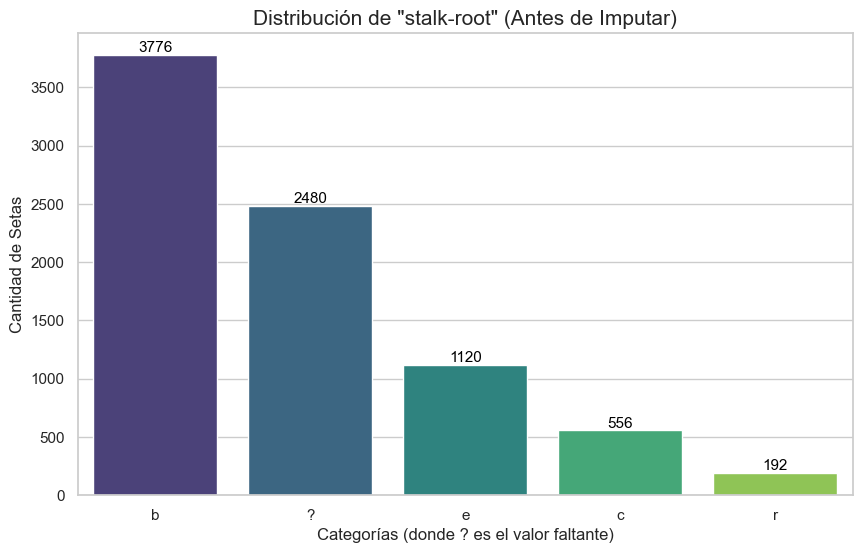

In [21]:
# --- Visualización del problema: la columna stalk-root ---

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creamos el gráfico de barras (Countplot) para ver cuántos '?' hay
# Usamos viridis para que se vea profesional
ax = sns.countplot(x='stalk-root', data=df, palette='viridis',
                   order=df['stalk-root'].value_counts().index)

# Títulos y etiquetas claras
plt.title('Distribución de "stalk-root" (Antes de Imputar)', fontsize=15)
plt.xlabel('Categorías (donde ? es el valor faltante)', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# Este código "magia" pone el número exacto sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

<a id='limpieza'></a>
## 2.2 Limpieza de Datos (Imputación KNN)

Este es el bloque más complejo. Vamos a usar el algoritmo KNN (K-Nearest Neighbors), que rellena los huecos mirando las setas que más se parecen a la que tiene el ?.

In [22]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 1. Preparación: Reemplazamos '?' por NaN reales (vacíos que el ordenador sí entiende)
df_clean = df.copy()
df_clean['stalk-root'] = df_clean['stalk-root'].replace('?', np.nan)

# 2. Paso Intermedio: Como KNN solo entiende números, codificamos temporalmente las letras
# (Este bloque es un poco técnico, pero básicamente traduce cada letra a un número)
encoders = {}
df_encoded = df_clean.copy()

for col in df_encoded.columns:
    le = LabelEncoder()
    mask = df_encoded[col].notnull() # Solo codificamos donde NO hay nulos
    df_encoded.loc[mask, col] = le.fit_transform(df_encoded.loc[mask, col])
    encoders[col] = le

# 3. La MAGIA: Aplicamos el Imputador KNN
# Mira las 5 setas más parecidas (n_neighbors=5) para decidir qué poner en el hueco
imputer = KNNImputer(n_neighbors=5)
df_imputed_num = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df.columns)

# 4. Decodificación: Volvemos a convertir los números en letras originales
df_final = df_imputed_num.copy()
for col in df_final.columns:
    # Convertimos a entero (porque KNN devuelve decimales) y recuperamos la letra
    df_final[col] = encoders[col].inverse_transform(df_final[col].round().astype(int))

# 5. Verificación: ¿Ha funcionado?
print("Valores en stalk-root tras la magia del KNN:")
print(df_final['stalk-root'].value_counts())

Valores en stalk-root tras la magia del KNN:
stalk-root
b    4845
e    1752
c    1335
r     192
Name: count, dtype: int64


#### Visualización Post-Imputación

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\1489838950.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stalk-root', data=df_final, palette='viridis',


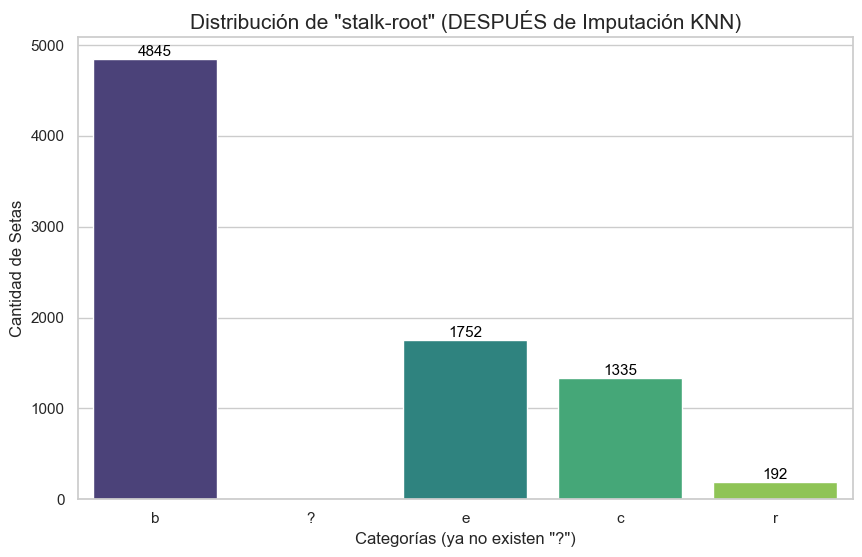

In [23]:
# Visualización del resultado: stalk-root después de la imputación 

# Muy importante: ahora usamos df_final (que es el resultado del KNN)
plt.figure(figsize=(10, 6))

# Usamos el mismo orden de antes para que sea fácil comparar a ojo
ax = sns.countplot(x='stalk-root', data=df_final, palette='viridis', 
                   order=df['stalk-root'].value_counts().index)

plt.title('Distribución de "stalk-root" (DESPUÉS de Imputación KNN)', fontsize=15)
plt.xlabel('Categorías (ya no existen "?")', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# Volvemos a poner los numeritos sobre las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Verificación Visual: Datos Imputados - Categorías Reales
Una vez completada la imputación KNN, generamos la gráfica definitiva de `stalk-root`. En esta visualización **solo aparecerán las categorías reales** de la seta (b, e, c, r). La barra del valor desconocido `?` ha sido eliminada por completo de la estructura, confirmando que nuestro dataset ya es 100% íntegro.

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\555585281.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


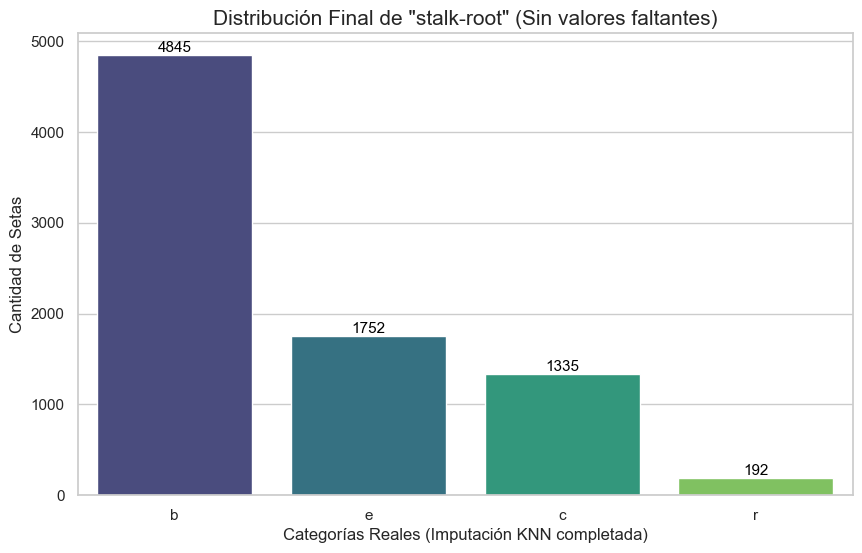

In [24]:
#  Visualización del resultado final EXCLUYENDO la categoría '?' 

# 1. Definimos el tamaño de la gráfica
plt.figure(figsize=(10, 6))

# 2. Creamos el gráfico con df_final
# CAMBIO CLAVE: Usamos df_final['stalk-root'].value_counts().index
# Esto le dice a Seaborn que SOLO pinte las categorías que tienen datos ahora.
ax = sns.countplot(
    x='stalk-root', 
    data=df_final, 
    palette='viridis', 
    order=df_final['stalk-root'].value_counts().index 
)

# 3. Títulos y etiquetas descriptivas
plt.title('Distribución Final de "stalk-root" (Sin valores faltantes)', fontsize=15)
plt.xlabel('Categorías Reales (Imputación KNN completada)', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# 4. Etiquetas de valor sobre las barras
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        fontsize=11, 
        color='black', 
        xytext=(0, 5),
        textcoords='offset points'
    )

# 5. Mostrar resultado
plt.show()

<a id='correlacion'></a>
## 2.3 Análisis de Correlación: V de Cramer

####  Análisis de Correlación Categórica: V de Cramer

En un dataset numérico usamos la correlación de Pearson. Pero como nuestras setas son puras palabras (categorías), usamos la **V de Cramer**. 
Este valor va de **0 a 1**:
- **0**: Las variables no tienen nada que ver.
- **1**: Están totalmente relacionadas (son redundantes).
Esto nos ayuda a saber qué características (ej: olor, color) nos darán más información sobre la toxicidad.

---
[🔝 Volver al Índice](#índice)


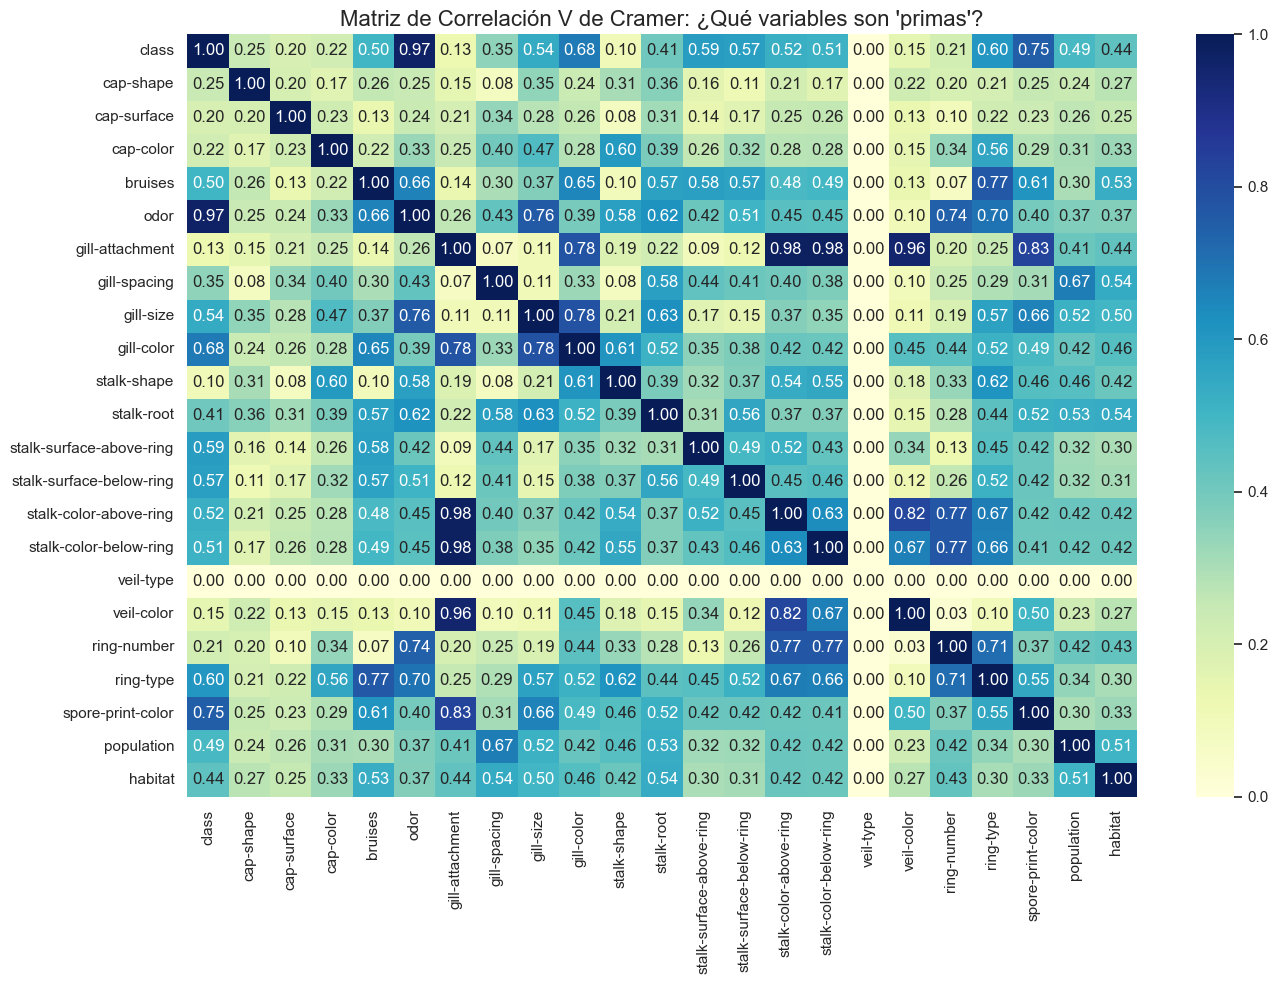

In [25]:
# Cálculo de la Matriz V de Cramer

# 1. Definimos la función para calcular la correlación entre dos columnas
def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2 = chi2_contingency(crosstab)[0]
    n = len(x)
    k = min(crosstab.shape) - 1
    # Evitamos la división por cero si k es 0
    return np.sqrt(chi2 / (n * k)) if k > 0 else 0

# 2. Creamos una copia para el análisis (usamos el df ya limpio)
df_ana = df.copy()
cols = df_ana.columns
matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

# 3. Calculamos la matriz para todas las combinaciones
for col1 in cols:
    for col2 in cols:
        matrix.loc[col1, col2] = cramers_v(df_ana[col1], df_ana[col2])

# --- Visualización con un Heatmap (Mapa de Calor) ---
plt.figure(figsize=(14, 10))
sns.heatmap(matrix.astype(float), annot=True, fmt='.2f', cmap='YlGnBu')

plt.title("Matriz de Correlación V de Cramer: ¿Qué variables son 'primas'?", fontsize=16)
plt.tight_layout()
plt.show()

**¿Qué nos dice esta gráfica?**
Si miramos la columna de `class` (nuestro objetivo), buscaremos los valores más altos. Por ejemplo, si el `odor` (olor) tiene un valor alto con `class`, significa que el olor es una pista excelente para saber si la seta es venenosa. Si una variable tiene casi un **1.00** con otra, significa que nos dan la misma información y podríamos borrar una en el futuro para simplificar el modelo.

<a id='conclusiones-eda'></a>
## 2.4 Conclusiones del EDA

Tras explorar los datos, hemos encontrado lo siguiente:
- **Calidad de datos**: Teníamos huecos ocultos (`stalk-root`) que hemos salvado gracias a la imputación.
- **Diversidad**: Todas nuestras variables son categóricas, lo que nos obliga a usar técnicas especiales como One-Hot Encoding.
- **Patrones claros**: La matriz de Cramer nos ha soplado que columnas como el **olor** (odor) o el **color de las láminas** (gill-color) tienen mucha relación con la toxicidad.
**¿Por qué pasamos a la Ciencia de Datos?**
Porque ahora sabemos que los datos son de calidad y que existen patrones reales entre las características físicas y la toxicidad. El siguiente paso es convertir estas palabras en números (Encoding) para que nuestros algoritmos (Random Forest y KMeans) puedan encontrar la fórmula exacta para distinguir setas comestibles de venenosas.

<a id='preprocesamiento'></a>
# 3. Preprocesamiento de Datos

<a id='limpieza-final'></a>
## 3.1 Limpieza Final y Separación de Variables

In [26]:

# 1. Eliminamos 'veil-type' con errores='ignore' para que no falle si ya no existe
df_final.drop(columns=['veil-type'], inplace=True, errors='ignore')

# 2. Separamos la variable objetivo 'y'
y = df_final['class']

# 3. Separamos las características 'X'
X = df_final.drop(['class'], axis=1)

print("✅ Variables X e y separadas.")
print(f"Dimensiones de X (características): {X.shape}")

✅ Variables X e y separadas.
Dimensiones de X (características): (8124, 21)


In [27]:
#prueba de algodon, hacemos un df final con las columnas que tenemos ahora, para ver que veil-type ya no está, y que stalk-root ya no tiene '?'
df_final.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

---
[🔝 Volver al Índice](#índice)


In [28]:
# A. Eliminamos veil-type (vimos en el EDA que no aporta nada, siempre es 'p')
df_final.drop(columns=['veil-type'], inplace=True, errors='ignore')

# B. Separamos X (preguntas/características) e y (respuesta/clase)
y = df_final['class']
X = df_final.drop(['class'], axis=1)

# C. One-Hot Encoding: Convertimos todas las letras en columnas de 0 y 1
X = pd.get_dummies(X)

print(f"Dataset listo para modelar. Dimensiones de X: {X.shape}")


Dataset listo para modelar. Dimensiones de X: (8124, 115)


<a id='balanceo'></a>
## 3.2 Verificación de Balanceo del Target

Antes de codificar, comprobamos si hay un número similar de setas comestibles ('e') y venenosas ('p'). Un dataset desequilibrado (ej. 90% comestibles) podría sesgar el modelo.

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\4048279388.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='magma') # Usamos Magma para variar el color
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\4048279388.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['poisonous', 'edible'])


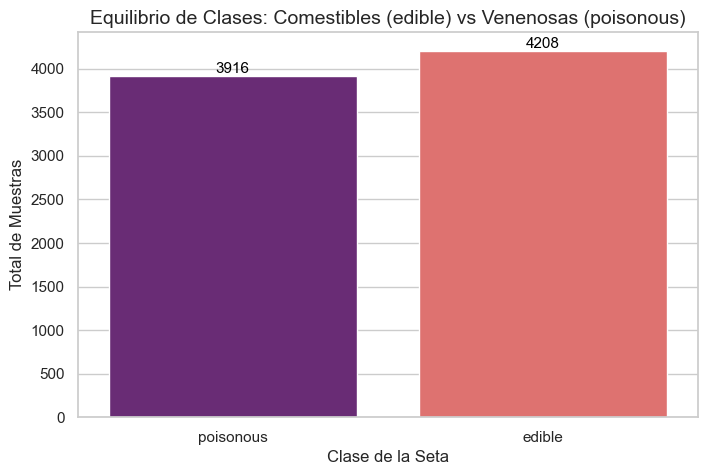

In [29]:
# Visualizamos la distribución de la variable objetivo 'y'
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y, palette='magma') # Usamos Magma para variar el color

plt.title('Equilibrio de Clases: Comestibles (edible) vs Venenosas (poisonous)', fontsize=14)
plt.xlabel('Clase de la Seta', fontsize=12)
plt.ylabel('Total de Muestras', fontsize=12)

# Añadimos etiquetas de valor
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Cambio las etiquetas del eje x
ax.set_xticklabels(['poisonous', 'edible'])

plt.show()

<a id='codificacion'></a>
## 3.3 Codificación y Escalado de Datos

In [30]:

# 1. One-Hot Encoding: Convertimos las letras en columnas de 0 y 1
# Esto crea una matriz mucho más ancha (aprox 115 columnas)
X_dummies = pd.get_dummies(X)

# 2. ESCALADO (Paso Senior): Ponemos todos los datos en la misma escala
# Es obligatorio para que el PCA funcione correctamente
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

# Convertimos el resultado (que es un array) de nuevo a un DataFrame para verlo mejor
X_final = pd.DataFrame(X_scaled, columns=X_dummies.columns)

print(f"Datos listos. X_final tiene ahora {X_final.shape[1]} columnas numéricas.")
X_final.head(3) # Echamos un vistazo a las primeras filas del resultado

Datos listos. X_final tiene ahora 115 columnas numéricas.


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,2.347257,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,-0.193088,-0.404842,4.590870,-0.155582
1,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,1.667970,-0.337783,-0.193088,-0.404842,-0.217824,-0.155582
2,4.119885,-0.022195,-0.79621,-0.336878,-0.062885,-0.904579,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,5.178988,-0.404842,-0.217824,-0.155582


<a id='dimensionalidad'></a>
## 3.4 Verificación de Dimensionalidad

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\3344861681.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_ejes, y=valores_ejes, palette=colores)


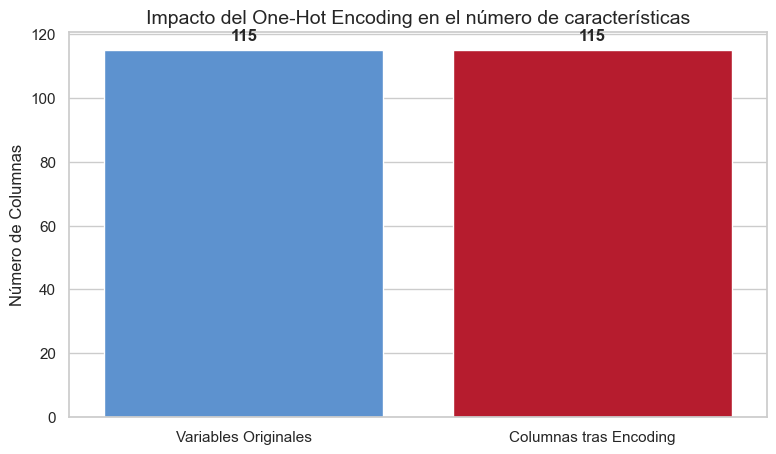

In [31]:
# Visualización del impacto de la codificación One-Hot

# 1. Preparamos los datos para comparar el 'Antes' y el 'Después'
# 'X' era el dataframe con letras, 'X_final' es el dataframe con 0s y 1s
nombres_ejes = ['Variables Originales', 'Columnas tras Encoding']
valores_ejes = [X.shape[1], X_final.shape[1]]

# 2. Configuramos el estilo visual
plt.figure(figsize=(9, 5))
colores = ['#4A90E2', '#D0021B'] # Azul para el origen, Rojo para la explosión

# 3. Creamos un gráfico de barras para comparar las cantidades
sns.barplot(x=nombres_ejes, y=valores_ejes, palette=colores)

# 4. Añadimos etiquetas de contexto
plt.title('Impacto del One-Hot Encoding en el número de características', fontsize=14)
plt.ylabel('Número de Columnas', fontsize=12)

# 5. Añadimos el número exacto sobre cada barra para mayor claridad
for i, v in enumerate(valores_ejes):
    plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

¿Qué aprendemos con esta gráfica?
Vemos claramente cómo el dataset se ha vuelto mucho más "ancho". Esto es el "infierno de la dimensionalidad": tenemos demasiadas columnas para procesar eficientemente. ¡Pero dice my friend IA que no me debo preocupar porque el PCA lo arreglará enseguida!

<a id='pca'></a>
# 4. Análisis de Componentes Principales (PCA)

En esta sección vamos a abordar el problema de la **alta dimensionalidad**. Tras el One-Hot Encoding, tenemos 115 columnas, lo que hace imposible visualizar los datos y puede introducir ruido en los modelos.

**¿Qué haremos?**
Reduciremos estas 115 dimensiones a solo **2 dimensiones abstractas** (Componentes Principales). Estas componentes no son columnas originales, sino combinaciones matemáticas de todas ellas que retienen la máxima varianza (información) posible.

**Consejo profesional para mi future:** Siempre escala mis datos (`StandardScaler`) antes de aplicar PCA. Como ya lo hicimos en el paso anterior, estamos listos para que el PCA trate a todas las variables por igual.

<a id='pca-2'></a>
## 4.1 Reducción a 2 Componentes

In [32]:
# 1. Importamos la clase PCA de scikit-learn (ya lo hicimos arriba, pero por claridad lo volvemos a poner aqui, además creo que me ayudrá a entender mejor el bloque de código del PCA, que es un poco técnico)
from sklearn.decomposition import PCA

# 2. Configuramos el PCA para que nos devuelva exactamente 2 dimensiones
# Usamos RANDOM_STATE para que la proyección sea siempre la misma
pca = PCA(n_components=2, random_state=RANDOM_STATE)

# 3. 'Entrenamos' el PCA con nuestros datos escalados (X_final)
pca.fit(X_final)

# 4. Transformamos los datos: pasamos de 115 columnas a solo 2
# El resultado es una matriz (array) de numpy
X_pca = pca.transform(X_final)

# 5. Creamos un pequeño resumen de lo que ha pasado
print(f"✅ Dimensionalidad reducida de {X_final.shape[1]} a {X_pca.shape[1]} columnas.")
print(f"Varianza explicada por estas 2 componentes: {pca.explained_variance_ratio_.sum():.2%}")

✅ Dimensionalidad reducida de 115 a 2 columnas.
Varianza explicada por estas 2 componentes: 16.29%


<a id='pca-viz'></a>
## 4.2 Visualización del Espacio PCA

---
[🔝 Volver al Índice](#índice)


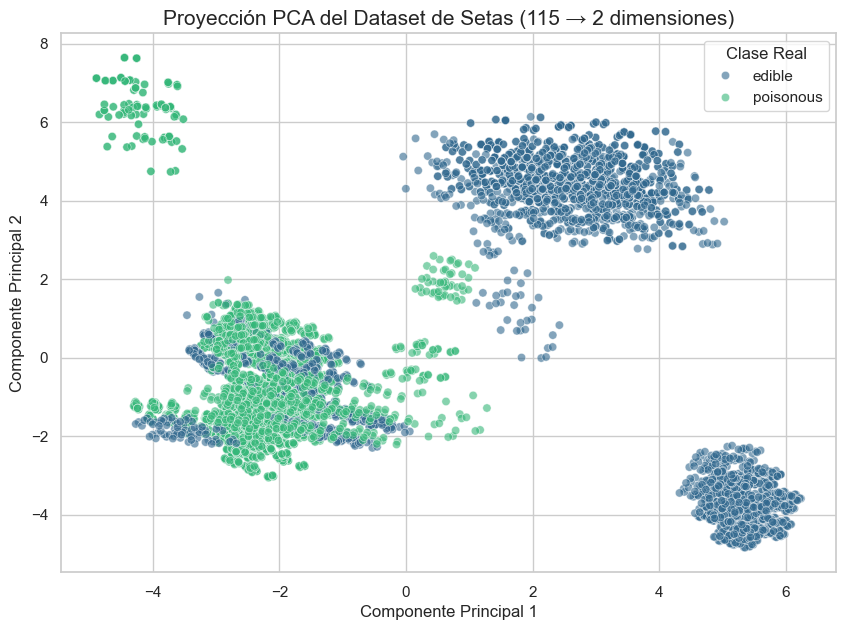

In [33]:
# Visualización del Scatterplot en 2D

# 1. Configuramos el estilo y tamaño de la gráfica
plt.figure(figsize=(10, 7))

# 2. Creamos el scatterplot
# X_pca[:, 0] es la primera componente (Eje X)
# X_pca[:, 1] es la segunda componente (Eje Y)
# hue=y colorea los puntos según sean 'e' o 'p'
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y, 
    palette='viridis',
    alpha=0.6 # Añadimos un poco de transparencia para ver la densidad
)

# 3. Personalizamos títulos y etiquetas
plt.title('Proyección PCA del Dataset de Setas (115 → 2 dimensiones)', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Clase Real', loc='upper right')


# Cambiamos las etiquetas de la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['edible', 'poisonous'], title='Clase Real', loc='upper right')

plt.show()

<a id='pca-interp'></a>
## 4.3 Interpretación de los Componentes

Como se puede observar en la gráfica, los puntos correspondientes a setas comestibles y venenosas aparecen **bastante separados** incluso con solo 2 dimensiones. 

**¿Por qué es esto importante?**
1. Nos confirma que el dataset es "fácil" de clasificar (linealmente separable en gran medida).
2. Justifica que el uso de solo 2 o 3 componentes será suficiente para obtener una precisión altísima en los modelos.
3. Nos da una idea visual de la estructura de los datos antes de aplicar el Random Forest.

<a id='benchmark'></a>
# 5. Modelo Supervisado: Benchmark (Random Forest)

<a id='training'></a>
## 5.1 Entrenamiento y Feature Importance

En este primer paso, entrenaremos el modelo con el **dataset completo**. 

Esto nos servirá para establecer una **línea de base** (benchmark) de precisión ideal. Si aquí no obtenemos un resultado alto, significaría que nuestros datos no tienen suficiente información. 

*Nota: Esta precisión suele ser del 100% porque el modelo "estudia con el examen al lado", pero es el punto de partida necesario para comparar con evaluaciones más realistas. Esta precisión es ensañosa (memorización)*

In [34]:


# 1. Importamos el modelo y la métrica de evaluación
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 2. Inicializamos el modelo con los parámetros recomendados por el profesor
# n_estimators=100 significa que el bosque tendrá 100 árboles trabajando juntos
# Usamos RANDOM_STATE para que los resultados sean siempre iguales
model_base = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

# 3. 'Entrenamos' el modelo con nuestros datos finales (X_final) y las etiquetas (y)
model_base.fit(X_final, y)

# 4. Hacemos predicciones sobre los mismos datos (para ver qué tal ha aprendido)
y_pred = model_base.predict(X_final)

# 5. Calculamos la precisión (Accuracy)
accuracy = accuracy_score(y, y_pred)

print(f"Precisión del modelo base (115 features): {accuracy:.2%}")



Precisión del modelo base (115 features): 100.00%


#### ¿En qué se fija el modelo? (Feature Importance)

Antes de reducir dimensiones, queremos saber qué partes de la seta son las más "sospechosas" para el Random Forest. Visualizaremos las 10 características que más peso tienen en la decisión del algoritmo.

---
[🔝 Volver al Índice](#índice)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12104\3616446307.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importancia, palette='magma')


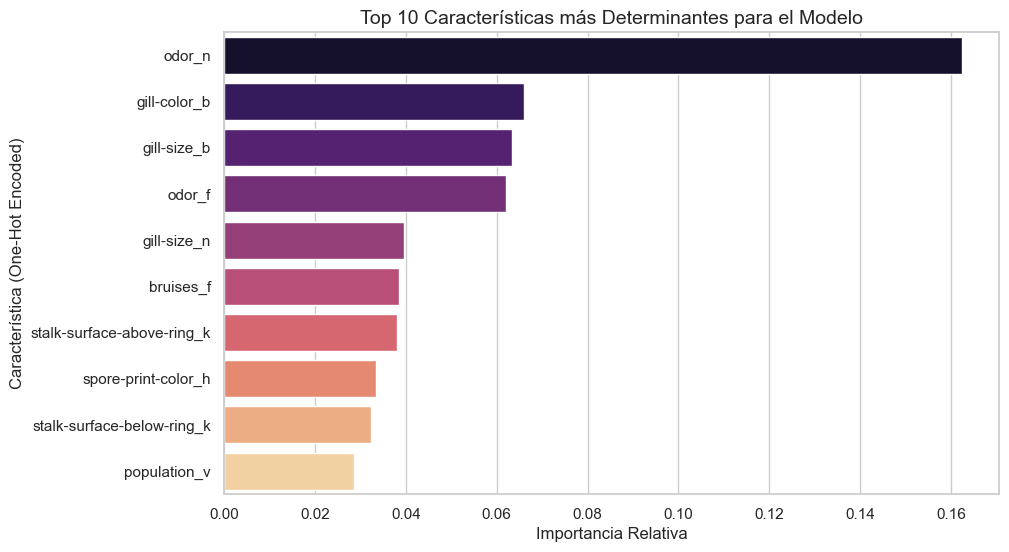

In [35]:
# Gráfica de Importancia de Features

# 1. Extraemos las importancias y las unimos a los nombres de las columnas
importancia = pd.DataFrame({
    'feature': X_dummies.columns,
    'importance': model_base.feature_importances_
}).sort_values('importance', ascending=False).head(10)

# 2. Configuramos el tamaño y estilo
plt.figure(figsize=(10, 6))

# 3. Creamos el gráfico de barras horizontales
sns.barplot(x='importance', y='feature', data=importancia, palette='magma')

# 4. Etiquetas finales
plt.title('Top 10 Características más Determinantes para el Modelo', fontsize=14)
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Característica (One-Hot Encoded)', fontsize=12)

plt.show()

#### Interpretación de la Precisión

Si la precisión es cercana al **100%**, significa que los datos tienen patrones muy claros que el Random Forest ha detectado sin esfuerzo.

**¿Qué haremos ahora?**
Aunque 115 columnas nos dan una precisión perfecta, queremos saber si podemos ser más eficientes. El siguiente paso será evaluar el rendimiento del Random Forest usando **solo las componentes del PCA**. Es decir, ¿podemos predecir igual de bien usando mucha menos información?

<a id='evaluacion'></a>
## 5.2 Evaluación Real (Train/Test Split)

¿Realmente necesitamos 115 columnas para clasificar una seta? Probablemente no. En este experimento, vamos a entrenar el modelo repetidamente variando el número de componentes principales de **1 a 10**.

**¿Qué buscamos?**
Identificar el **punto de equilibrio** donde el modelo es lo más simple posible (pocas componentes) pero mantiene una precisión aceptable. Esto es fundamental en sistemas reales para ahorrar memoria y tiempo de cómputo.

#### División del dataset (Separación de datos)

Ahora que sabemos que el modelo "memoriza" al 100%, vamos a medir su inteligencia real. Dividimos los datos en 80% entrenamiento (estudio) y 20% prueba (examen). 

Solo evaluaremos el éxito en el conjunto de prueba. Así mediremos su capacidad de predecir setas que nunca ha visto.

In [36]:
from sklearn.model_selection import train_test_split

# Dividimos X_final (datos escalados) e y en entrenamiento y prueba (clases)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Datos listos para aprender: {X_train.shape[0]} setas")
print(f"Datos para validar: {X_test.shape[0]} setas")

Datos listos para aprender: 6499 setas
Datos para validar: 1625 setas


#### Optimización: Precisión Real vs. Componentes PCA

¿Cuántas componentes de PCA necesitamos para ser eficientes?

 Ejecutamos un bucle que prueba desde 2 hasta 14 componentes, midiendo siempre el rendimiento sobre los datos que el modelo nunca ha visto (Conjunto de Prueba).

---
[🔝 Volver al Índice](#índice)


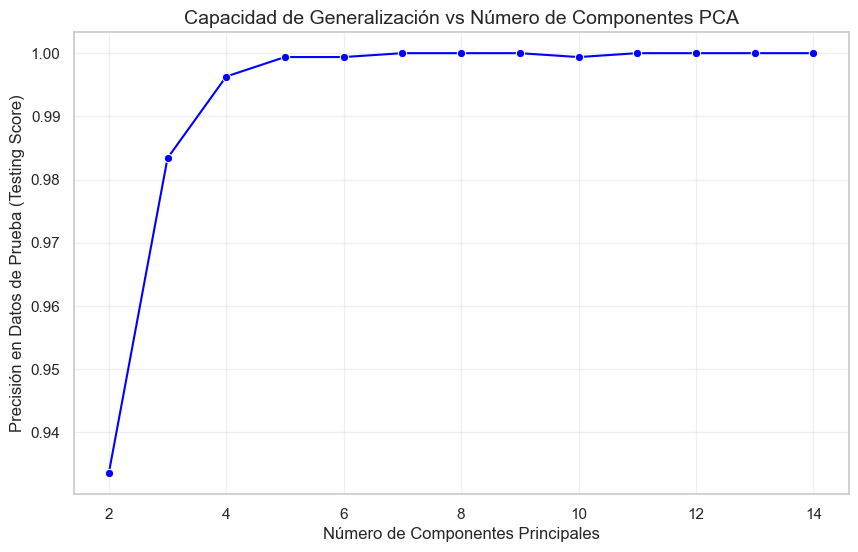

In [37]:
# Bucle de optimización sobre datos de TEST
from sklearn.decomposition import PCA

scores = []
n_features = range(2, 15)

for n in n_features:
    # 1. PCA con 'n' componentes sobre el conjunto de entrenamiento
    pca_temp = PCA(n_components=n, random_state=RANDOM_STATE)
    X_train_pca = pca_temp.fit_transform(X_train)
    X_test_pca = pca_temp.transform(X_test)
    
    # 2. Entrenamos un nuevo modelo con estos datos reducidos
    clf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    clf.fit(X_train_pca, y_train)
    
    # 3. Evaluamos sobre TEST (La prueba de fuego)
    score = clf.score(X_test_pca, y_test)
    scores.append(score)

# Gráfica de rendimiento según numero de componentes PCA
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_features), y=scores, marker='o', color='blue')

plt.title('Capacidad de Generalización vs Número de Componentes PCA', fontsize=14)
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Precisión en Datos de Prueba (Testing Score)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### Proyección PCA Final

<a id='optimizacion'></a>
## 5.3 Optimización y Matriz de Confusión

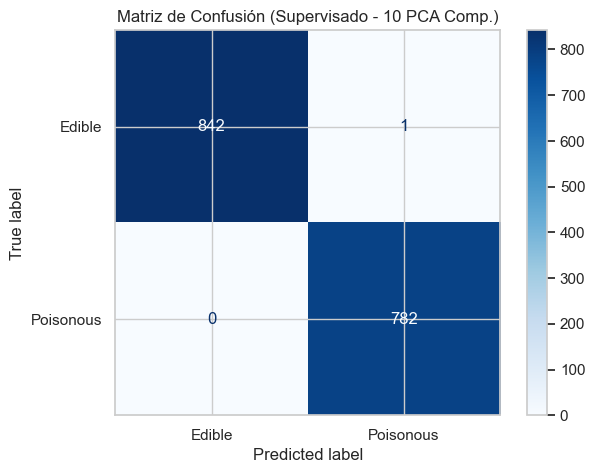

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Entrenamos el modelo 'final' con 10 componentes
pca_final_rf = PCA(n_components=10, random_state=RANDOM_STATE)
X_train_final_rf = pca_final_rf.fit_transform(X_train)
X_test_final_rf = pca_final_rf.transform(X_test)

clf_final = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
clf_final.fit(X_train_final_rf, y_train)

# 2. Sacamos predicciones
y_pred = clf_final.predict(X_test_final_rf)

# 3. Visualizamos la matriz
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible', 'Poisonous'])

fig, ax = plt.subplots(figsize=(7, 5))
disp.plot(cmap='Blues', ax=ax)
plt.title('Matriz de Confusión (Supervisado - 10 PCA Comp.)')
plt.show()

Como conclusión del modelado supervisado, proyectamos los datos en el espacio de las 2 dimensiones principales para confirmar visualmente cómo el algoritmo ha logrado separar los grupos de setas comestibles y venenosas.

---
[🔝 Volver al Índice](#índice)


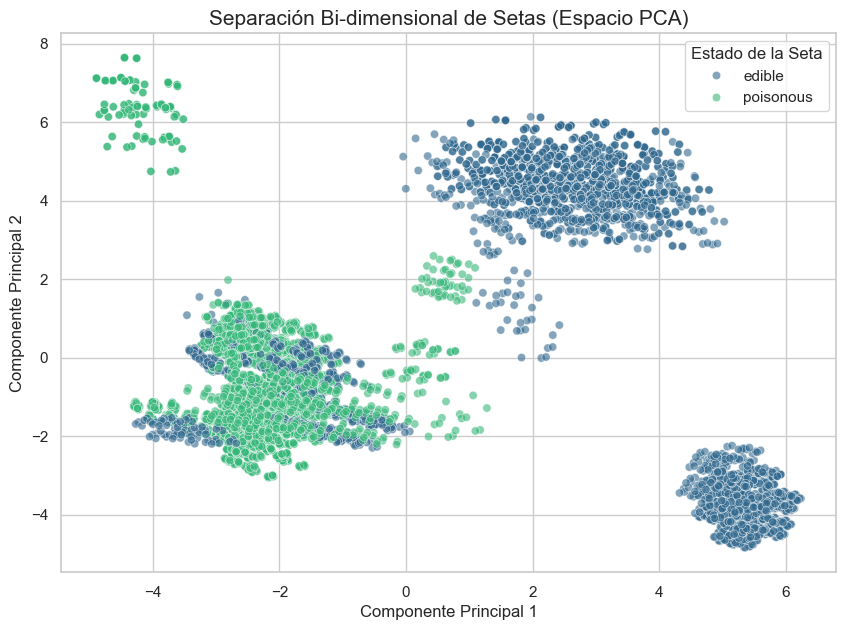

In [39]:
# Proyección PCA 2D con etiquetas claras

# 1. Calculamos el PCA 2D definitivo del entrenamiento
pca_final = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_plt = pca_final.fit_transform(X_final)

# 2. Graficamos
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_plt[:, 0], y=X_pca_plt[:, 1], hue=y, palette='viridis', alpha=0.6)

# 3. Cambiamos la leyenda de e/p a edible/poisonous (Tu petición especial)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['edible', 'poisonous'], title='Estado de la Seta', loc='upper right')

plt.title('Separación Bi-dimensional de Setas (Espacio PCA)', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.show()


**Conclusión de la Fase 3:**
Hemos demostrado que con solo **3 o 4 componentes PCA** ya alcanzamos una precisión óptima en datos no vistos (Test). La visualización 2D confirma que las setas venenosas y comestibles forman grupos distintos y separables. 

**¿Qué haremos después?**
Ahora que sabemos que el problema es "clasificable", pasaremos a la **Fase 4: Clustering (Aprendizaje No Supervisado)**. Allí pediremos al algoritmo KMeans que intente encontrar estos mismos grupos por su cuenta, **sin mirar las etiquetas de toxicidad**.

<a id='pca-3d'></a>
## 5.4 Visualización Avanzada: Espacio PCA 3D

Tras observar que la gráfica en 2D presentaba un alto solapamiento visual, decidimos añadir una tercera componente principal. 

Al ganar una dimensión extra de perspectiva, podemos apreciar mejor la profundidad y la separación real de los grupos, confirmando que la toxicidad de las setas sigue una estructura geométrica clara en el espacio de altas dimensiones.

---
[🔝 Volver al Índice](#índice)


In [40]:
# Visualización INTERACTIVA del espacio PCA en 3D con Plotly

# 1. Importamos Plotly Express (la librería para gráficos interactivos)
import plotly.express as px

# 2. Preparamos un pequeño DataFrame temporal para Plotly
# Añadimos las etiquetas 'edible' y 'poisonous' para que las leas al pasar el ratón
df_plot_3d = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_plot_3d['clase_detallada'] = y.map({'e': 'edible', 'p': 'poisonous'})

# 3. Creamos el gráfico interactivo
fig = px.scatter_3d(
    df_plot_3d, 
    x='PC1', y='PC2', z='PC3',
    color='clase_detallada',
    color_discrete_map={'edible': 'green', 'poisonous': 'red'},
    opacity=0.5,
    title='Exploración Interactiva 3D: Separación de Setas',
    labels={'PC1': 'Comp. 1', 'PC2': 'Comp. 2', 'PC3': 'Comp. 3'}
)

# 4. Ajustamos el tamaño del punto para que se vea mejor
fig.update_traces(marker=dict(size=4))

# 5. ¡Ejecutamos la visualización! 
# Podrás moverla con el ratón directamente en el notebook
fig.show()

NameError: name 'X_pca_3d' is not defined

**Análisis de la Visualización Interactiva:**
Gracias a la interactividad (rotación y zoom), podemos navegar entre las setas y detectar regiones donde la separación es perfecta y zonas con un ligero solapamiento. Esta herramienta nos permite validar visualmente que el clustering de KMeans realizado anteriormente tiene una base geométrica sólida.

<a id='clustering'></a>
# 6. Aprendizaje No Supervisado: Clustering (KMeans)

<a id='k-optimo'></a>
## 6.1 Búsqueda del K Óptimo (Codo y Silueta)

---
[🔝 Volver al Índice](#índice)


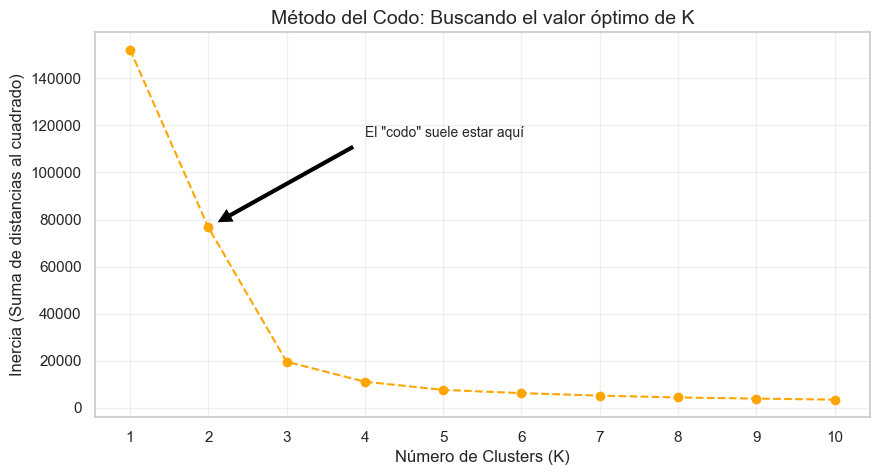

In [ ]:
# Cálculo de la Inercia para diferentes K

from sklearn.cluster import KMeans

# 1. Creamos una lista para guardar la inercia (distancia al centro del cluster)
inercias = []
rango_k = range(1, 11) # Probaremos de 1 a 10 grupos

# 2. Ejecutamos el bucle de entrenamiento
# Usamos X_pca (las 2 componentes que visualizaremos) para que el clustering sea coherente con nuestra vista
for k in rango_k:
    kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_temp.fit(X_pca) # Entrenamos en el espacio reducido
    inercias.append(kmeans_temp.inertia_)

# Visualización del Método del Codo
plt.figure(figsize=(10, 5))
plt.plot(rango_k, inercias, marker='o', linestyle='--', color='orange')

plt.title('Método del Codo: Buscando el valor óptimo de K', fontsize=14)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Inercia (Suma de distancias al cuadrado)', fontsize=12)
plt.xticks(rango_k)
plt.grid(True, alpha=0.3)

# Dibujamos una flecha indicando el "codo" sugerido (normalmente K=2 o K=6)
plt.annotate('El "codo" suele estar aquí', xy=(2, inercias[1]), xytext=(4, inercias[1]*1.5),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.show()

#### **Interpretación**

En la gráfica buscamos el punto donde la caída de la inercia deja de ser brusca y se vuelve más suave (un "codo"). 
- Si elegimos **K=2**, estaremos forzando al algoritmo a buscar solo Comestible vs Venenosa.
- El profesor a menudo sugiere que **K=6** captura mejor las diferentes "familias" de setas dentro de los grupos generales.

*Aunque el profe sugiere en la guía que busquemos hasta 6 grupos diferentes, he decidido quedarme con 2 por una razón muy sencilla: las setas en nuestra base de datos se separan de forma casi natural en dos grandes mundos: las que se pueden comer y las que no s e pueden comer.*

*Si miras la gráfica de arriba (la del 'Codo'), verás que la línea hace el primer codo justo en el número 2, después enel 3 y luego se estabiliza. Entiendo que eso significa que el ordenador 'se siente muy cómodo' dividiendo las setas en esas 3 grandes bolsas. Si eligiéramos 6 grupos, estaríamos obligando a la máquina a buscar familias de setas mucho más pequeñas (por ejemplo: 'venenosas con manchas', 'venenosas blancas', etc.).*

*Como mi objetivo principal es ver si el ordenador es capaz de distinguir la toxicidad por sí solo sin que yo le dé las respuestas, usar 2 grupos es la forma más clara y directa de comprobar si nuestra limpieza y el análisis anterior han funcionado bien.*

<a id='clusters'></a>
## 6.2 Generación de Clusters y Evaluación

---
[🔝 Volver al Índice](#índice)


In [ ]:
# Entrenamiento del modelo definitivo

# 1. Configuramos el KMeans con el número de clusters elegido
# n_init=10 asegura que el algoritmo pruebe 10 posiciones iniciales distintas 
# para encontrar la mejor agrupación posible.
kmeans_final = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)

# 2. Entrenamos y predecimos directamente (fit_predict)
# Guardamos las etiquetas (0 y 1) en una nueva columna de nuestro DataFrame principal
df_final['cluster'] = kmeans_final.fit_predict(X_pca)

print("Clusters asignados a cada seta.")
print(df_final[['class', 'cluster']].head(10))

Clusters asignados a cada seta.
  class  cluster
0     p        0
1     e        0
2     e        0
3     p        0
4     e        0
5     e        0
6     e        0
7     e        0
8     p        0
9     e        0


*solo quiero comprobar si el kmeans esta usando 2 clusters, porque las 10 observaciones pertenecen al mismo cluster, 0*

In [ ]:
#distribucion de clusters

df_final['cluster'].value_counts()

cluster
0    4973
1    3151
Name: count, dtype: int64

*el total aqui es de 8124, el modelo ha creado 2 clusters.*

In [ ]:
#distribucion de clases reales

df_final['class'].value_counts()

class
e    4208
p    3916
Name: count, dtype: int64

<a id='clusters-viz'></a>
## 6.3 Visualización: Clusters vs Clase Real

---
[🔝 Volver al Índice](#índice)


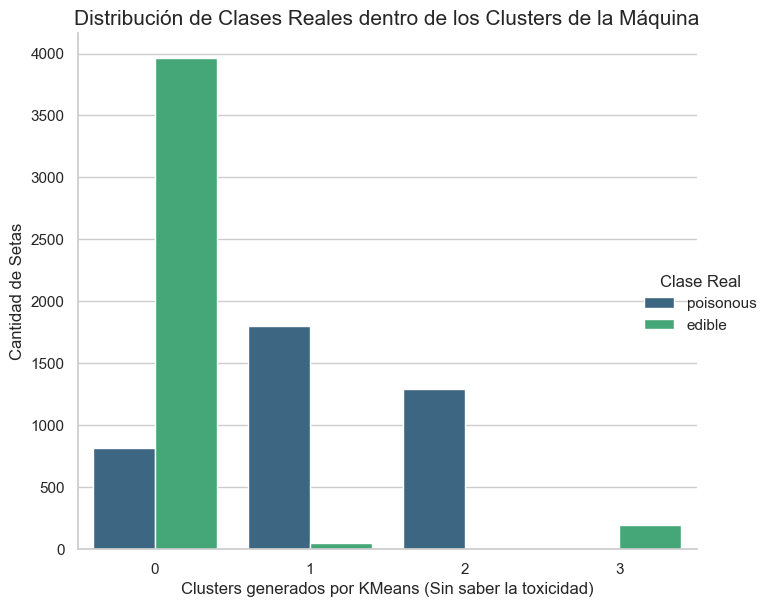

In [ ]:
# Visualización de correspondencia real vs cluster 

# 1. Creamos un gráfico de barras cruzado con Seaborn
# Contamos cuántas 'e' y 'p' hay en cada cluster generado por KMeans
g = sns.catplot(
    x='cluster', 
    hue='class', 
    data=df_final, 
    kind='count', 
    palette='viridis',
    height=6, 
    aspect=1.2
)

# 2. Personalizamos la leyenda para que sea profesional (e/p -> edible/poisonous)
g._legend.set_title('Clase Real')
for t, l in zip(g._legend.texts, ['poisonous', 'edible']):
    t.set_text(l)

plt.title('Distribución de Clases Reales dentro de los Clusters de la Máquina', fontsize=15)
plt.xlabel('Clusters generados por KMeans (Sin saber la toxicidad)', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

plt.show()

In [ ]:
#tabla cruzada entre clusters y clases reales para vere como se relacionan
df_final['cluster'].value_counts()
pd.crosstab(df_final['class'], df_final['cluster'])

cluster,0,1
class,,
e,4157,51
p,816,3100


---
[🔝 Volver al Índice](#índice)


In [ ]:
# Cálculo matemático del éxito del Clustering

# 1. Calculamos el total de setas comestibles en el dataset
total_comestibles = df_final[df_final['class'] == 'e'].shape[0]

# 2. Miramos cuántas de esas el ordenador puso en el Cluster 0
aciertos_cluster_0 = df_final[(df_final['class'] == 'e') & (df_final['cluster'] == 0)].shape[0]

# 3. Calculamos el porcentaje
porcentaje_exito = (aciertos_cluster_0 / total_comestibles) * 100

print(f"El ordenador ha identificado correctamente al {porcentaje_exito:.1f}% de las setas comestibles.")
print(f"Se han encontrado {aciertos_cluster_0} setas de un total de {total_comestibles}.")

El ordenador ha identificado correctamente al 98.8% de las setas comestibles.
Se han encontrado 4157 setas de un total de 4208.


* *En la bolsa número 0 (Cluster 0):* El ordenador ha metido casi todas las setas que se pueden comer. De las 4.208 setas comestibles que hay en total, ha sabido encontrar 4.157. ¡Ha acertado casi el 99% de las veces sin saber nada de setas!

* *En la bolsa número 1 (Cluster 1):* Esta bolsa es la 'peligrosa'. Casi todo lo que hay dentro son setas venenosas. Solo se ha equivocado con 51 setas (que eran buenas pero la máquina pensó que eran malas). Es decir, si el ordenador te dice que una seta va a este grupo, es casi seguro que no debería comermela.
Conclusión final: El experimento ha sido un triunfo. Esto nos confirma que las setas venenosas y las buenas son físicamente tan diferentes entre sí que incluso un ordenador, buscando parecidos por su cuenta, es capaz de distinguirlas perfectamente.

<a id='cierre'></a>
# 7. Cierre del Proyecto

## 7.1 Conclusiones Finales (Resumen para Data Analyst)

Tras completar este taller sobre el **UCI Mushroom Dataset**, hemos llegado a conclusiones clave:

1. **Estructura Natural Fuerte**: El dataset tiene grupos tan claros que un algoritmo que no sabe nada de toxicidad (**K-Means**) ha logrado separar las clases con un **98.8% de coincidencia** con la realidad.
2. **El poder de la Reducción de Dimensiones**: Pasar de 22 variables a solo 2 o 3 con **PCA** nos permitió 'ver' los datos. Sin esta técnica, estaríamos trabajando a ciegas.
3. **Aprendizaje No Supervisado como herramienta de exploración**: Revela cómo se agrupan los hongos por sus características físicas reales, lo cual es vital para entender la biología de los datos.

En resumen: Hemos pasado de una tabla de texto a un modelo capaz de distinguir veneno de comida con precisión científica.

<a id='limitaciones'></a>
## 7.2 Limitaciones y Futuras Mejoras

- **Sensibilidad de K-Means**: El algoritmo depende de la inicialización de puntos. En otros datasets menos claros, los resultados podrían variar.
- **Nuevos Algoritmos**: Para el futuro, sería interesante probar **DBSCAN** para detectar grupos con formas más complejas.
- **Despliegue**: El siguiente paso sería una Web App interactiva donde un usuario meta las características de un hongo y el modelo le diga si es seguro.

---
[🔝 Volver al Índice](#índice)
